# Doubly Nudged Elastic Band Method

We demonstrate the Doubly Nudged Elastic Band algorithm from Cleary & Page (2023), to compute energy-minimising pathways between equilibria of the point vortex system in a rotating domain.

### Initial Imports

In [3]:
import jax
import jax.numpy as jnp
from jax import jit
import VorticesMotion as vm
import loss_functions as lf
import velocity_transforms as vt
import dneb
import newton as nt
import utils
import optax
from functools import partial

import pickle
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)

### Compute the Energy-Minimising Pathways

In [5]:
n = 10

# read in all equilibria with n vortices

eq_in_file = 'data/n'+str(n)

with open(eq_in_file, 'rb') as f:
    full_data = pickle.load(f)

equilibria = full_data['params']
delta_f = full_data['delta_f']

gammas = jnp.ones(n)
ind = utils.indices(n)

# order the REQ by \Delta f
sorted_ind = jnp.argsort(delta_f)
equilibria = equilibria[sorted_ind]
delta_f = delta_f[sorted_ind]

# compute the rate of rotation of the domain
omega = vt.mean_angular_velocity(equilibria[0], gammas, ind, n)

index1 = 0
index2 = 1
eq1 = equilibria[index1]
eq2 = equilibria[index2]

# compute the energy minimising pathway
interpolation, eq1, eq2 = dneb.main(n, eq1, eq2, omega, gammas)

2023-05-09 17:16:16.216411
Optimiser Step 0: loss = DeviceArray(-703.04347637, dtype=float64)
Optimiser Step 10: loss = DeviceArray(-703.04671066, dtype=float64)
Optimiser Step 20: loss = DeviceArray(-703.04703347, dtype=float64)
Optimiser Step 30: loss = DeviceArray(-703.04709334, dtype=float64)
Optimiser Step 40: loss = DeviceArray(-703.04710938, dtype=float64)
Optimiser Step 50: loss = DeviceArray(-703.04711721, dtype=float64)
Optimiser Step 60: loss = DeviceArray(-703.0471233, dtype=float64)
Optimiser Step 70: loss = DeviceArray(-703.04712895, dtype=float64)
Optimiser Step 80: loss = DeviceArray(-703.04713447, dtype=float64)
Optimiser Step 90: loss = DeviceArray(-703.04713993, dtype=float64)
Optimiser Step 100: loss = DeviceArray(-703.04714537, dtype=float64)


### Visualise the Pathway

In [6]:
# function to compute \Delta f for each interpolation state
vmapped_df = jax.vmap(vm._return_full_delta_f_omegafixed, (0, None, None, None, None))

# non-dimensionalise the rate of rotation of the domain
df_interpolation = vmapped_df(interpolation, gammas, ind, n, 2. * jnp.pi * omega)

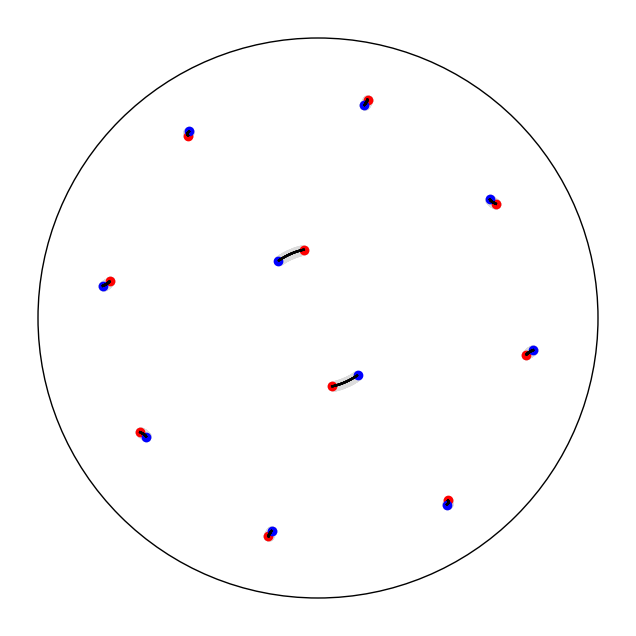

In [12]:
# visualise the pathway in physical space

fig, ax = plt.subplots(1, figsize=(8,8))
N_interpolate = len(interpolation)

ax.scatter(interpolation[0, :n], interpolation[0, n:], color='gainsboro')
for i in range(1,N_interpolate):
    ax.scatter(interpolation[i, :n], interpolation[i, n:], color='gainsboro')
    for k in range(n):
        ax.plot([interpolation[i-1, k],interpolation[i, k]],[interpolation[i-1, k+n],interpolation[i, k+n]],'k')
        
ax.scatter(eq1[:n], eq1[n:], color='red')
ax.scatter(eq2[:n], eq2[n:], color='blue')
r_max = jnp.max(jnp.sqrt(eq1[:n]**2 + eq1[n:]**2))
circle = plt.Circle((0, 0), r_max*1.25, fill=False, color='black')
ax.add_patch(circle)
ax.set_axis_off()
ax.set_box_aspect(1)
plt.show()

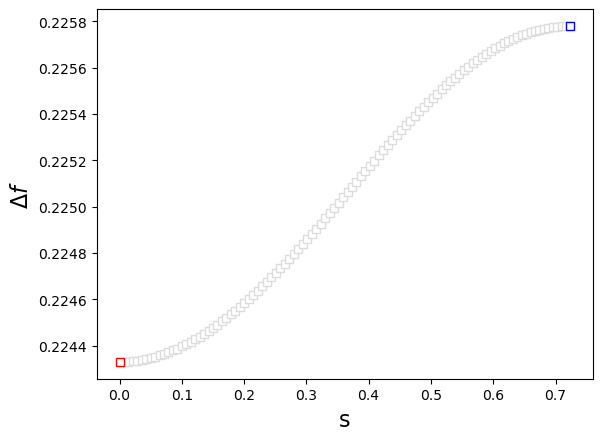

In [20]:
# visualise the free energy landscape along the pathway

fig, ax = plt.subplots(1)

s = 0. # will be the arc length parameter

s += jnp.linalg.norm(interpolation[0] - eq1)
ax.plot(s, df_interpolation[0], c='w', marker='s', markeredgecolor='gainsboro', markersize=6)
slist = [0., s]

for i in range(1, N_interpolate):
    s += jnp.linalg.norm(interpolation[i] - interpolation[i-1])
    ax.plot(s, df_interpolation[i], c='w', marker='s', markeredgecolor='gainsboro', markersize=6)
    slist.append(s)

ax.plot(0, vm._return_full_delta_f_omegafixed(eq1, gammas, ind, n, 2. * jnp.pi * omega), c='w', marker='s', markeredgecolor='red', markersize=6)

s += jnp.linalg.norm(eq2 - interpolation[-1])
slist.append(s)
ax.plot(s, vm._return_full_delta_f_omegafixed(eq2, gammas, ind, n, 2. * jnp.pi * omega), c='w', marker='s', markeredgecolor='blue', markersize=6)
ax.set_xlabel('s', fontsize=16)
ax.set_ylabel('$\\Delta f$', fontsize=16)
plt.show()